In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed, AdditiveAttention, Attention, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data
import string
vi_input = []
with open(f"vi_data.txt", encoding = 'utf-8') as f:
  for line in f:
    line = line.replace('  ', ' ').lower()
    vi_input.append(line.strip())

ja_input = []
with open(f"ja_data.txt", encoding = 'utf-8') as f:
  for line in f:
    ja_input.append(line.strip())

for i in zip(ja_input[:1], vi_input[:1]):
  print(i)


('私は眠らなければなりません。', 'tôi phải đi ngủ .')


In [3]:
# Thêm token đánh dấu điểm bắt đầu và kết thúc của câu vào mỗi câu trong ngôn ngữ đích
eos = '<eos>'
bos = '<bos>'

from pyvi import ViTokenizer
vi_input_tokenize = [ViTokenizer.tokenize(i).split() for i in vi_input]


import spacy
nlp = spacy.load("ja_core_news_sm")
ja_input_tokenize = [[] for i in range(len(ja_input))]
for i in range(len(ja_input)):
  doc = nlp(ja_input[i])
  for token in doc:
    ja_input_tokenize[i].append(str(token))

for i in range(len(ja_input_tokenize)):
  ja_input_tokenize[i].insert(0, bos)
  ja_input_tokenize[i].insert(len(ja_input_tokenize[i]), eos)


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

ja_tokenizer = Tokenizer(oov_token = '<oov>')
ja_tokenizer.fit_on_texts(ja_input_tokenize)
ja_vocabulary = ja_tokenizer.word_index
ja_size = len(ja_vocabulary)
print(ja_vocabulary)
print(ja_size) # number of words in the vocabulary

vi_tokenizer = Tokenizer()
vi_tokenizer.fit_on_texts(vi_input_tokenize)
vi_vocabulary = vi_tokenizer.word_index
vi_size = len(vi_vocabulary)
print(vi_vocabulary)
print(vi_size)


{'<oov>': 1, '<bos>': 2, '<eos>': 3, '。': 4, 'は': 5, 'の': 6, 'に': 7, 'た': 8, 'を': 9, 'て': 10, 'が': 11, '私': 12, 'で': 13, 'し': 14, '彼': 15, 'ない': 16, '、': 17, 'だ': 18, 'か': 19, 'と': 20, 'です': 21, 'いる': 22, '？': 23, 'ます': 24, 'い': 25, 'も': 26, '彼女': 27, 'こと': 28, '！': 29, 'ん': 30, '何': 31, 'その': 32, 'あなた': 33, 'な': 34, 'よ': 35, 'この': 36, '「': 37, '」': 38, 'まし': 39, 'ある': 40, 'から': 41, 'する': 42, '人': 43, 'お': 44, 'ませ': 45, 'よう': 46, 'なかっ': 47, 'それ': 48, '誰': 49, 'いい': 50, 'たら': 51, 'ね': 52, 'たち': 53, 'たい': 54, '好き': 55, '日': 56, '・': 57, 'どう': 58, '君': 59, 'とても': 60, 'さ': 61, 'でき': 62, 'もの': 63, 'ば': 64, 'てる': 65, '語': 66, '中': 67, '言っ': 68, '時間': 69, 'くれ': 70, 'どこ': 71, 'なら': 72, '話し': 73, 'より': 74, 'これ': 75, '見': 76, 'へ': 77, '子供': 78, '方': 79, 'そう': 80, 'もう': 81, '家': 82, '来': 83, 'トム': 84, '仕事': 85, 'なり': 86, 'だっ': 87, '勉強': 88, '僕': 89, 'たくさん': 90, '車': 91, 'れ': 92, '達': 93, '今日': 94, 'でしょう': 95, '本当': 96, 'あり': 97, 'せ': 98, '雨': 99, 'なけれ': 100, 'すぐ': 101, '金': 102, 'つもり': 103, 'なっ':

In [5]:
ja_vocabulary_reverse = {}
for key, value in ja_tokenizer.word_index.items():
  ja_vocabulary_reverse[value] = key
ja_vocabulary_reverse[0] = ''

vi_vocabulary_reverse = {}
for key, value in vi_tokenizer.word_index.items():
  vi_vocabulary_reverse[value] = key
vi_vocabulary_reverse[0] = ''

print(ja_vocabulary_reverse)
print(vi_vocabulary_reverse)


{1: '<oov>', 2: '<bos>', 3: '<eos>', 4: '。', 5: 'は', 6: 'の', 7: 'に', 8: 'た', 9: 'を', 10: 'て', 11: 'が', 12: '私', 13: 'で', 14: 'し', 15: '彼', 16: 'ない', 17: '、', 18: 'だ', 19: 'か', 20: 'と', 21: 'です', 22: 'いる', 23: '？', 24: 'ます', 25: 'い', 26: 'も', 27: '彼女', 28: 'こと', 29: '！', 30: 'ん', 31: '何', 32: 'その', 33: 'あなた', 34: 'な', 35: 'よ', 36: 'この', 37: '「', 38: '」', 39: 'まし', 40: 'ある', 41: 'から', 42: 'する', 43: '人', 44: 'お', 45: 'ませ', 46: 'よう', 47: 'なかっ', 48: 'それ', 49: '誰', 50: 'いい', 51: 'たら', 52: 'ね', 53: 'たち', 54: 'たい', 55: '好き', 56: '日', 57: '・', 58: 'どう', 59: '君', 60: 'とても', 61: 'さ', 62: 'でき', 63: 'もの', 64: 'ば', 65: 'てる', 66: '語', 67: '中', 68: '言っ', 69: '時間', 70: 'くれ', 71: 'どこ', 72: 'なら', 73: '話し', 74: 'より', 75: 'これ', 76: '見', 77: 'へ', 78: '子供', 79: '方', 80: 'そう', 81: 'もう', 82: '家', 83: '来', 84: 'トム', 85: '仕事', 86: 'なり', 87: 'だっ', 88: '勉強', 89: '僕', 90: 'たくさん', 91: '車', 92: 'れ', 93: '達', 94: '今日', 95: 'でしょう', 96: '本当', 97: 'あり', 98: 'せ', 99: '雨', 100: 'なけれ', 101: 'すぐ', 102: '金', 103: 'つもり', 104: 

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

ja_sequence = ja_tokenizer.texts_to_sequences(ja_input_tokenize)
jamaxlen = max([len(i) for i in ja_sequence]) 
ja_sequence = pad_sequences(ja_sequence, maxlen = jamaxlen, padding = 'post')
print(ja_sequence[0])

vi_sequence = vi_tokenizer.texts_to_sequences(vi_input_tokenize)
vimaxlen = max([len(i) for i in vi_sequence])
vi_sequence = pad_sequences(vi_sequence, maxlen = vimaxlen, padding = 'post')
print(vi_sequence[0])


[  2  12   5 782 100  64  86  45  30   4   3   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
[  2  27  19 131   1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]


In [7]:
split_ratio = 0.9
split = round(len(vi_sequence)* split_ratio)
trainX = vi_sequence[:split]
testX = vi_sequence[split:]
trainY = ja_sequence[:split]
testY = ja_sequence[split:]

train_samples = len(trainX)
val_samples = len(testX)
batch_size = 128
epochs = 150
latent_dim=300


In [8]:
def generate_batch(X, y, batch_size):
  while True:
    for j in range(0, len(X), batch_size):
      encoder_input_data = []
      decoder_input_data = []
      decoder_target_data = []
      for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
        encoder_input_data.append(input_text)   
        decoder_input_data.append(target_text)
        decodertargetdata = to_categorical(target_text, num_classes=ja_size+1)[1:]
        decoder_target_data.append(np.concatenate((np.array(decodertargetdata), np.zeros((1, ja_size+1))), axis = 0))
      encoder_input_data = np.array(encoder_input_data)
      decoder_input_data = np.array(decoder_input_data)
      decoder_target_data = np.array(decoder_target_data)
      yield((encoder_input_data, decoder_input_data), decoder_target_data)


In [9]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(vi_size+1, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [10]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(ja_size+1, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(ja_size+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [11]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['acc'])
history = model.fit(generate_batch(trainX, trainY, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(testX, testY, batch_size = batch_size),
                    validation_steps = val_samples//batch_size,
                    )

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 659ms/step - acc: 0.1302 - loss: 7.3576 - val_acc: 0.0154 - val_loss: 5.1665
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step - acc: 0.4239 - loss: 5.2144 - val_acc: 0.8631 - val_loss: 4.8048
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - acc: 0.3330 - loss: 4.8885 - val_acc: 0.0493 - val_loss: 4.5382
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 564ms/step - acc: 0.0506 - loss: 4.6211 - val_acc: 0.0514 - val_loss: 4.3452
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - acc: 0.0529 - loss: 4.4276 - val_acc: 0.0541 - val_loss: 4.1993
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 573ms/step - acc: 0.0552 - loss: 4.2519 - val_acc: 0.0544 - val_loss: 4.0717
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 571ms/step - acc: 0.0570 - loss: 4.1164 - val_acc: 0.0559 - val_loss: 3.9670
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - acc: 0.0596 - loss: 4.0154 - val_acc: 0.0575 - val_loss: 3.8814
Epoch 9/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 587ms

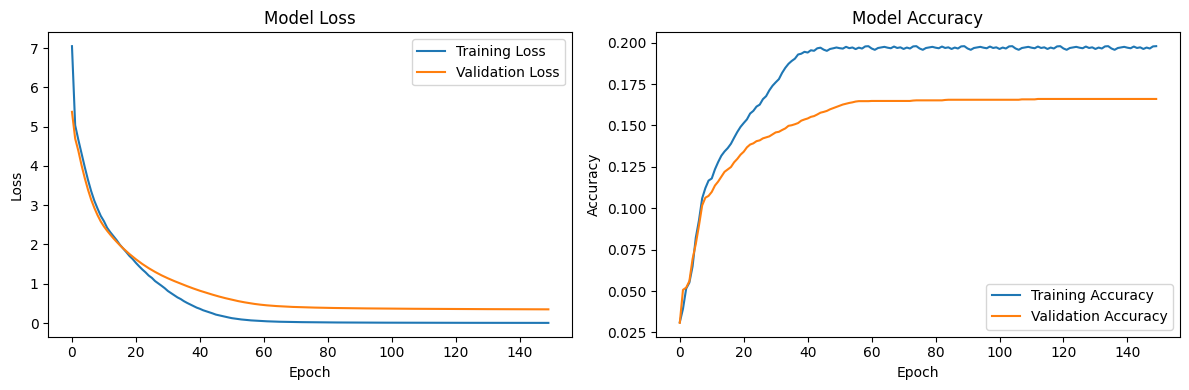

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)


In [30]:
def preprocess_input_text(input_text, tokenizer, max_len):
    seq = tokenizer.texts_to_sequences([input_text])
    seq = pad_sequences(seq, maxlen=max_len, padding='post')
    return seq


In [31]:
def decode_sequence(input_seq):

    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))

    target_seq[0, 0] = ja_vocabulary[bos]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
       
        sampled_word =ja_vocabulary_reverse[sampled_token_index]
        decoded_sentence += ' '+ sampled_word

        if (sampled_word == eos or
           len(decoded_sentence) > 100):
            stop_condition = True
       
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
  
        states_value = [h, c]
    return decoded_sentence


In [36]:
input_text = input("Nhập câu tiếng Việt: ")

input_seq = preprocess_input_text(input_text, vi_tokenizer, vimaxlen)

decoded_sentence = decode_sequence(input_seq)

print("Câu Tiếng Việt:", input_text)
print("Dịch Tiếng Nhật:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Câu Tiếng Việt: phải đi ngủ
Dịch Tiếng Nhật:  私 は 眠ら なけれ ば なり ませ ん 。 <eos>


In [15]:
test_gen = generate_batch(testX, testY, batch_size = 1)
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Câu tiếng Việt:', ''.join([vi_vocabulary_reverse[i] for i in input_seq[0]]))
print('Câu tiếng Nhật:', ' '.join([ja_vocabulary_reverse[i] for i in actual_output[0]]))
print('Câu tiếng Nhật dự đoán:', decoded_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Câu tiếng Việt: anhhọctiếngla-tinhtừbao_giờ?
Câu tiếng Nhật: <bos> あなた は いつ から ラテン 語 を 勉強 し まし た か 。 <eos>                                                  
Câu tiếng Nhật dự đoán:  あなた は いつ から ラテン 語 を 勉強 し まし た か 。 <eos>


In [38]:
import os
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

folder = r"F:\DPL\project4\finale\model\wav2vec2_VN"

from transformers import AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor, Wav2Vec2Processor, AutoConfig

config = AutoConfig.from_pretrained(folder)

tokenizer = AutoTokenizer.from_pretrained(os.path.join(folder, "tokenizer"))
feature_extractor = AutoFeatureExtractor.from_pretrained(os.path.join(folder, "feature_extractor"))
processor = Wav2Vec2Processor.from_pretrained(os.path.join(folder, "processor"))

model = AutoModelForCTC.from_config(config)
model.load_state_dict(torch.load(os.path.join(folder, "model.pth"), map_location=device))
model.to(device)
model.eval()


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [39]:
def VietnameseSpeechRecognition(arrTensor):
  inputs = processor(arrTensor, sampling_rate=16000, return_tensors="pt")
  inputs = inputs.to(device)
  with torch.no_grad():
      logits = model(**inputs).logits
      predicted_ids = torch.argmax(logits, dim=-1)
      transcription = processor.batch_decode(predicted_ids)
      return transcription[0]

In [ ]:
import os
import numpy as np
import gradio as gr
import scipy.signal as sps
import torch

def ReSampleAudio(data, current_rate, new_rate=16000):
    samples = round(len(data) * float(new_rate) / current_rate)
    return sps.resample(data, samples)

def process_and_translate(audio):
    sr, dataArr = audio

    dataArr = ReSampleAudio(dataArr, sr)

    inputs = torch.tensor(dataArr)

    input_text = VietnameseSpeechRecognition(inputs)

    input_seq = preprocess_input_text(input_text, vi_tokenizer, vimaxlen)

    decoded_sentence = decode_sequence(input_seq)

    return f"Câu tiếng Việt: {input_text}\nDịch tiếng Nhật: {decoded_sentence}"

demo = gr.Interface(
    fn=process_and_translate,
    inputs="microphone",
    outputs="text",
    title="Dịch tiếng Việt sang tiếng Nhật qua giọng nói",
    description="Nói tiếng Việt đê!",
    cache_examples=False
)

demo.launch()
